### Helpful APT motor functions

Run the first cell before restarting the kernel to prevent Kinesis drivers from
interfering.

Run the second cell if you want to refresh the list of available motors

In [7]:
# Close APT motors gracefully to avoid kernel crash
apt.core._cleanup()


<WinDLL 'c:\Users\PushinQuantum\Documents\PythonScripts\slm-imaging\.venv\Lib\site-packages\thorlabs_apt\APT.dll', handle 180000000 at 0x192f5df3650>

In [ ]:
# Run this cell to refresh list of motors
apt.core._cleanup()
apt.core._load_library()

## Setup

Run these cells when first starting up the program and after 
restarting the kernel.

If there is a `the kernel has died` error message, most likely it is the 
Thorlabs kinesis driver interfering with the APT driver. To fix:

1. Restart jupyter kernel
2. Open kinesis application
3. Connect and load all motors
4. Disconnect all devices
5. Restart jupyter kernel
6. Run `Setup` cells - it should now work correctly

To prevent this in the future, make sure to run `apt.core._cleanup()` before
restarting or killing the kernel.

In [2]:
import pyvisa as visa
from ThorlabsPM100 import ThorlabsPM100
import thorlabs_apt as apt
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import IPython.display as dis
import time
from datetime import date
import os
from tqdm import tqdm


In [8]:
# Setup power meter and motors
rm = visa.ResourceManager()
inst = rm.open_resource("USB0::0x1313::0x8078::P0024196::INSTR")


def averaged_power(
    N_samples: int = 100, delay_sample: float = 0.001
) -> tuple[float, float]:
    """
    Returns the mean power measured from the powermeter over N_samples
    taken with a delay of delay_sample.

    Automatically rejects inf values returned by the power_meter.

    Args:
        N_samples: number of measurements to take.
        delay_sample: wait time between measurements in seconds.

    Returns:
        mean: average value of measurements.
        error: standard deviation of measurements.
    """
    measurement_array = np.zeros(N_samples)
    power_meter = ThorlabsPM100(inst=inst)
    for i in range(N_samples):
        measurement = power_meter.read
        while not np.isfinite(measurement):
            time.sleep(delay_sample)
            measurement = power_meter.read
        measurement_array[i] = measurement
        time.sleep(delay_sample)
    mean = np.nanmean(measurement_array)
    error = np.nanstd(measurement_array)
    return mean, error


# Thorlabs Motors setup
device_list = apt.list_available_devices()
motor_tuple = ()
for device in device_list:
    if device[1] == 27259423 or device[1] == 27259011:
        polarizer = apt.Motor(device[1])
        motor_tuple += (polarizer,)
    elif device[1] == 27259243 or device[1] == 27258072:
        analyzer = apt.Motor(device[1])
        motor_tuple += (analyzer,)
    else:
        print("Device not recognized.")
print(f"{len(motor_tuple)} Thorlabs Motors Loaded")

for motor in motor_tuple:
    max_velocity = motor.get_velocity_parameter_limits()
    motor.set_velocity_parameters(0, *max_velocity)
    motor.move_home()


def polarizer_wait() -> None:
    """Wait till the polarizers are done moving."""
    motion_flag = True
    while motion_flag:
        motion_flag = polarizer.is_in_motion or analyzer.is_in_motion

def cosine(x, a, b, phi):
    return a + b * np.cos(2 * np.radians(x + phi))


2 Thorlabs Motors Loaded


# Polarizer & Analyzer Alignment Test

In [4]:
###############
# Measurement #
###############

power_array = []
polarizer_angles = np.arange(0, 361, 5)
analyzer_angles = np.arange(0, 361, 5)

polarizer.move_home(blocking=True)

for polarizer_angle in tqdm(polarizer_angles):
    polarizer.move_to(polarizer_angle)
    analyzer.move_home()
    polarizer_wait()
    power_list = []
    for analyzer_angle in analyzer_angles:
        analyzer.move_to(analyzer_angle)
        polarizer_wait()
        power_list.append(averaged_power())
    power_array.append(power_list)

power_array = np.array(power_array)

# Some filename definitions
date_str = date.today().isoformat().replace("-", "")
sample = "polarizer_alignment_test"
image_folder = "D:/data/{}/{}/pol/{}/".format(
    date_str[0:4],
    date_str,
    sample,
)

# np.save(f"{image_folder}polarizer_alignment_test.npy", power_array)

############
# Analysis #
############

phi_array = []
phi_error = []
extinction_ratio = []


for polarizer_angle, power_list in zip(polarizer_angles, power_array):
    popt, pcov = opt.curve_fit(
        cosine,
        analyzer_angles,
        power_list[:, 0],
        bounds=([0, 0, 0], [1, 1, 180]),
    )
    # plt.plot(range(360), cosine(range(360), *popt))
    # plt.plot(analyzer_angles, power_list[:, 0], 'o')
    # plt.show()
    phi_array.append(popt[2])
    pcovperr = np.sqrt(np.diag(pcov))
    phi_error.append(pcovperr[2])
    a, b, phi = popt
    a = np.abs(a)
    b = np.abs(b)
    extinction_ratio.append((a + b) / (a-b))


offset = (phi_array + polarizer_angles) % 180
mean = np.mean(offset)
std = np.std(offset)
print("Average Offset is ({:0.2f} +/- {:0.2f}) degrees".format(mean, std))

plt.figure(figsize=(12, 6), dpi=100)
plt.errorbar(
    polarizer_angles,
    offset,
    yerr=phi_error,
)
plt.title(f"Polarizer Analyzer Offset (mean = {mean:0.2f} +/- {std:0.2f})")
plt.ylabel("Polarizer Analyzer Offset [deg]")
plt.xlabel("Polarizer Angle [deg]")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(polarizer_angles, extinction_ratio)
plt.title("Extinction Ratio")
plt.ylabel("Extinction Ratio (higher is better)")
plt.xlabel("Polarizer Angle [deg]")
plt.show()

# Polarizer Analyzer Rotation Heap Map
plt.figure(figsize=(12,6))
plt.pcolormesh(
    np.arange(0, 361, 5), 
    np.arange(0, 361, 5), 
    power_array[:, :, 0], 
    # norm=colors.LogNorm(vmin=1e-5, vmax=5e-3), 
    cmap='jet', 
    shading='auto'
)
plt.colorbar(label='Intensity [W]')
plt.title("Intensity Map of Polarizer and Analyzer Rotation Angles")
plt.xlabel("Analyzer Angle [deg]")
plt.ylabel("Polarizer Angle [deg]")
plt.show()

100%|██████████| 73/73 [2:36:38<00:00, 128.75s/it]  


# Waveplate Circularity Test

A quick and useful test to measure the circularity of polarization in the beam, 
typically to characterize the alignment of a quarter waveplate and polarizer
pair (to normalize laser intensity as the polarizer rotates).

100%|██████████| 25/25 [00:55<00:00,  2.22s/it]

Variance (curve fit) is: -97.456%
$\phi$ phase shift (curve fit) is: 1.468
Variance (std) is: 73.038%


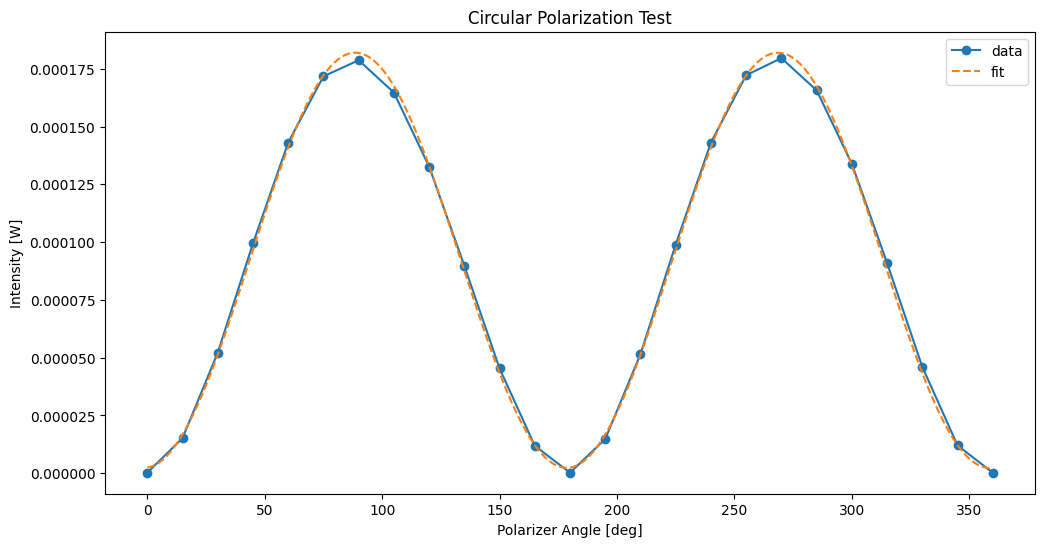

In [10]:
###############
# Measurement #
###############

power_array = []
polarizer_angles = np.arange(0, 361, 15)

polarizer.move_home()
# analyzer.move_home()
polarizer_wait()

for polarizer_angle in tqdm(polarizer_angles):
    polarizer.move_to(polarizer_angle)
    # analyzer.move_to(analyzer_angle)
    polarizer_wait()
    power_array.append(averaged_power()[0])

power_array = np.array(power_array)

############
# Analysis #
############

popt, pcov = opt.curve_fit(
        cosine, polarizer_angles, power_array, p0=[0, 1, 0]
)
mean = np.mean(power_array)
std = np.std(power_array)
print(f"Variance (curve fit) is: {popt[1] / popt[0] * 100:.3f}%")
print(f"phi phase shift (curve fit) is: {popt[2]:.3f} deg")
print(f"Variance (std) is: {std / mean * 100:.3f}%")
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(polarizer_angles, power_array, 'o-', label='data')
plt.plot(range(360), cosine(range(360), *popt), '--', label='fit')
plt.title("Circular Polarization Test")
plt.ylabel("Intensity [W]")
plt.xlabel("Polarizer Angle [deg]")
plt.legend()
plt.show()
